In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.optimizers import SR3
#import sdeint


# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
import sys
sys.path.append('C:/Users/wp7528/Documents/islands_models_ulrich/Stochastic-modelling-of-power-grid-frequency-applied-to-islands')

from utils.Data_cleaning import data_cleaning
from utils.Functions import data_filter, integrate_omega, KM_Coeff_1, KM_Coeff_2, daily_profile, power_mismatch, exp_decay

In [26]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
#The first plot shows how well the model's predictions match the test data, 
#while the second plot shows how well the simulated data matches the test data for different threshold values. 

#Plot the MSE of the discovered model against the threshold values.

#Plot the MSE between the actual and simulated test data against the threshold values.

In [36]:
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    xticknames = ["$" + name + "$" for name in xticknames]  # LaTeX formatting
    plt.figure(figsize=(18, 8))

    # First subplot for ensemble mean and standard deviation
    plt.subplot(1, 2, 1)
    plt.title("Ensemble Coefficients", fontsize=24)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    colors = ["b", "r", "k"]
    for i in range(mean_ensemble.shape[0]):
        plt.errorbar(
            range(mean_ensemble.shape[1]),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i % len(colors)],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    ax.set_yscale("log")  # Set y-scale to log
    ax.set_xticks(range(len(xticknames)))
    #ax.set_xticklabels(xticknames, fontsize=20, rotation=90)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=16, loc="upper left")

    # Second subplot for the library ensemble mean and standard deviation
    plt.subplot(1, 2, 2)
    plt.title("Library Ensemble Coefficients", fontsize=24)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(mean_library_ensemble.shape[0]):
        plt.errorbar(
            range(mean_library_ensemble.shape[1]),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i % len(colors)],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    ax.set_yscale("log")  # Set y-scale to log
    ax.set_xticks(range(len(xticknames)))
    #ax.set_xticklabels(xticknames, fontsize=20, rotation=90)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=16, loc="upper left")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [54]:
def plot_ensemble(
    model, mean_ensemble, std_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    xticknames = ["$" + name + "$" for name in xticknames]  # LaTeX formatting
    plt.figure(figsize=(12, 6))

    # First subplot for ensemble mean and standard deviation
    plt.title("Ensemble Coefficients", fontsize=24)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    colors = ["b", "r", "k"]
    for i in range(mean_ensemble.shape[0]):
        plt.errorbar(
            range(mean_ensemble.shape[1]),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i % len(colors)],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    ax.set_yscale("log")  # Set y-scale to log
    ax.set_xticks(range(len(xticknames)))
    #ax.set_xticklabels(xticknames, fontsize=20, rotation=90)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=14, loc="upper left")
    plt.show()

In [4]:
import matplotlib.pyplot as plt

def plot_theta_omega_comparisons(t, original_theta, simulated_theta, original_omega, simulated_omega):
    """
    Plots the comparison of original and simulated theta and omega over time.

    Parameters:
    - t: Time array
    - original_theta: Array of original theta values
    - simulated_theta: Array of simulated theta values
    - original_omega: Array of original omega values
    - simulated_omega: Array of simulated omega values
    """
    
    plt.figure(figsize=(12, 6))

    # Plot original and simulated theta
    plt.subplot(1, 2, 1)
    plt.plot(t, original_theta, label='Original Theta')
    plt.plot(t, simulated_theta, label='Simulated Theta', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Theta')
    plt.title('Theta Comparison')
    plt.legend()

    # Plot original and simulated omega
    plt.subplot(1, 2, 2)
    plt.plot(t, original_omega, label='Original Omega')
    plt.plot(t, simulated_omega, label='Simulated Omega', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.title('Omega Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Linear time dependent

#### 1. t is not included as a feature, t doesn't appear in the SINDy output. Even though the model score is high, the comparison plot is different.

In [5]:
# Constants
c1 = 1e-3  
c2 = 1e-5  

# ODEs system
def minus_t(t, y):
    theta, omega = y
    theta_dot = omega
    omega_dot = -c1 * omega - c2 * theta - t
    return [theta_dot, omega_dot]


# Generate measurement data
dt = 1

t_train = np.arange(0, 900, dt)
x0_train = [-0.1, 0.1]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(minus_t, t_train_span, x0_train,
                    t_eval=t_train, **integrator_keywords).y.T


In [6]:
# Feature names for SINDy 
feature_names = ["theta", "omega"]

sparse_regression_optimizer = ps.STLSQ(threshold=1e-80)
#differentiation_method = ps.SmoothedFiniteDifference()
#differentiation_method = ps.FiniteDifference(order=2)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=sparse_regression_optimizer
                 #,
                 #differentiation_method=differentiation_method
                )

# Fit the model as usual
model.fit(x_train, t=dt, ensemble=True, quiet=True)
#model.fit(x_train, t=dt)
model.print(precision=6)
model.score(x_train, t=dt)

(theta)' = -0.155983 1 + 0.999997 omega
(omega)' = -0.000006 1 + -0.000341 theta + 0.025208 omega


0.9921608774687596

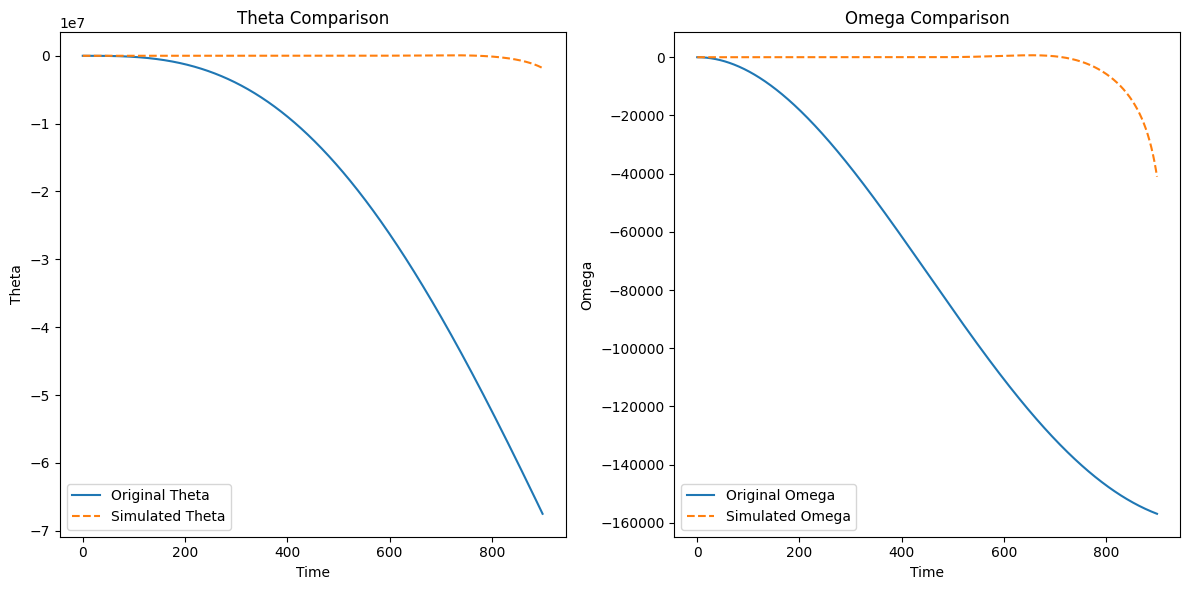

In [7]:
x0_augmented = np.array([x0_train[0], x0_train[1]])
# Simulate the dynamics using the SINDy model
x_simulated = model.simulate(x0_augmented, t_train)

# Extract original and simulated theta and omega
original_theta = x_train[:, 0]
simulated_theta = x_simulated[:, 0]
original_omega = x_train[:, 1]
simulated_omega = x_simulated[:, 1]

plot_theta_omega_comparisons(t_train, original_theta, simulated_theta, original_omega, simulated_omega)


### 2.1 include t as a feature, including a interaction term f0(omega,time)

### 2.2 include t as a feature, finally no interaction terms!

In [5]:
import numpy as np
import pysindy as ps
from scipy.integrate import solve_ivp

# Constants
c1 = 1e-3  
c2 = 1e-5  

# ODEs system
def minus_t(t, y):
    theta, omega = y
    theta_dot = omega
    omega_dot = -c1 * omega - c2 * theta - t
    return [theta_dot, omega_dot]

# Generate measurement data
dt = 1
t_train = np.arange(0, 900, dt)
x0_train = [-0.01, 0.001]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(minus_t, t_train_span, x0_train, t_eval=t_train).y.T

# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary(degree=1)

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-50)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt)
model.print(precision=5)
print("Model Score:", model.score(x_train_augmented, t=dt))


(theta)' = -8.07786 1 + 1.00013 omega + -0.08827 linear_time
(omega)' = 0.03600 1 + -0.00001 theta + -0.00100 omega + 1.00035 linear_time
(linear_time)' = -1.00000 1
Model Score: 0.6666653872961931


In [81]:
#BENJAMIN EXPERIMENt
#import numpy as np
import pysindy as ps
from scipy.integrate import solve_ivp

# Constants
c1 = 1e-1  
c2 = 1e-3  

# ODEs system
def minus_t(t, y):
    theta, omega = y
    theta_dot = omega
    omega_dot = 5-c1 * omega - c2 * theta - 0.01*t
    return [theta_dot, omega_dot]

# Generate measurement data
dt = 1
t_train = np.arange(0, 900, dt)
x0_train = [-0.01, 0.001]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(minus_t, t_train_span, x0_train, t_eval=t_train).y.T

# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary(degree=1)

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-5)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt)
model.print(precision=4)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = -0.0003 1 + 0.9998 omega
(omega)' = 5.0039 1 + -0.0010 theta + -0.1001 omega + 0.0100 linear_time
(linear_time)' = -1.0000 1
Model Score: 0.6666633674465537


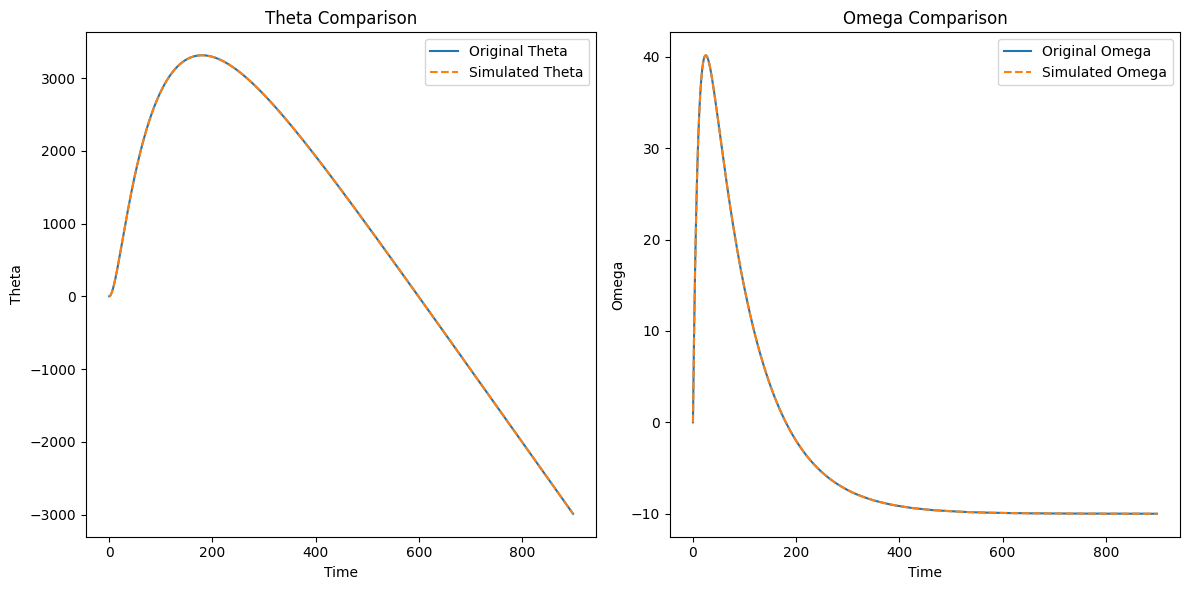

In [61]:
# Augment initial condition with the starting time (0 in this case)
x0_augmented = np.array([x0_train[0], x0_train[1], 0])  # Append 0 for time

# Simulate the dynamics using the SINDy model
x_simulated = model.simulate(x0_augmented, t_train)

# Extract original and simulated theta and omega
original_theta = x_train[:, 0]
simulated_theta = x_simulated[:, 0]
original_omega = x_train[:, 1]
simulated_omega = x_simulated[:, 1]

plot_theta_omega_comparisons(t_train, original_theta, simulated_theta, original_omega, simulated_omega)


In [90]:
# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt, ensemble=True, quiet=True)
ensemble_coefs = model.coef_list

# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

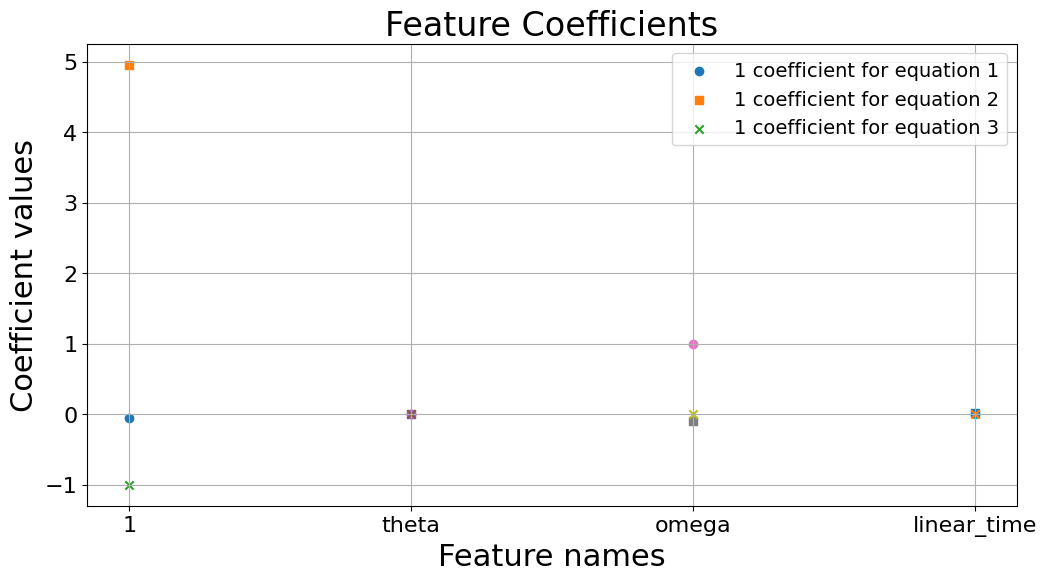

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_coefficients(feature_names, mean_ensemble):
    # Assume that each row of mean_ensemble corresponds to an equation
    # and each column corresponds to a feature.
    
    num_equations = mean_ensemble.shape[0]
    num_features = len(feature_names)
    
    # Check if the number of features matches the size of the mean_ensemble
    if mean_ensemble.shape[1] != num_features:
        raise ValueError("The number of features does not match the mean ensemble shape.")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.title("Feature Coefficients", fontsize=24)
    plt.xlabel("Feature names", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)

    # Define markers for each equation for clarity
    markers = ['o', 's', 'x']

    # Loop over each feature and plot the coefficients for each equation
    for i in range(num_features):
        for eq in range(num_equations):
            plt.scatter(
                i,  # x position for this feature
                mean_ensemble[eq, i],  # y position for the coefficient of this feature
                label=f"{feature_names[i]} coefficient for equation {eq + 1}" if i == 0 else "",
                marker=markers[eq]
            )
    
    # Customize ticks and labels
    plt.xticks(ticks=np.arange(num_features), labels=feature_names, fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.show()

# Call the function with the mean ensemble coefficients
plot_feature_coefficients(feature_names, mean_ensemble)


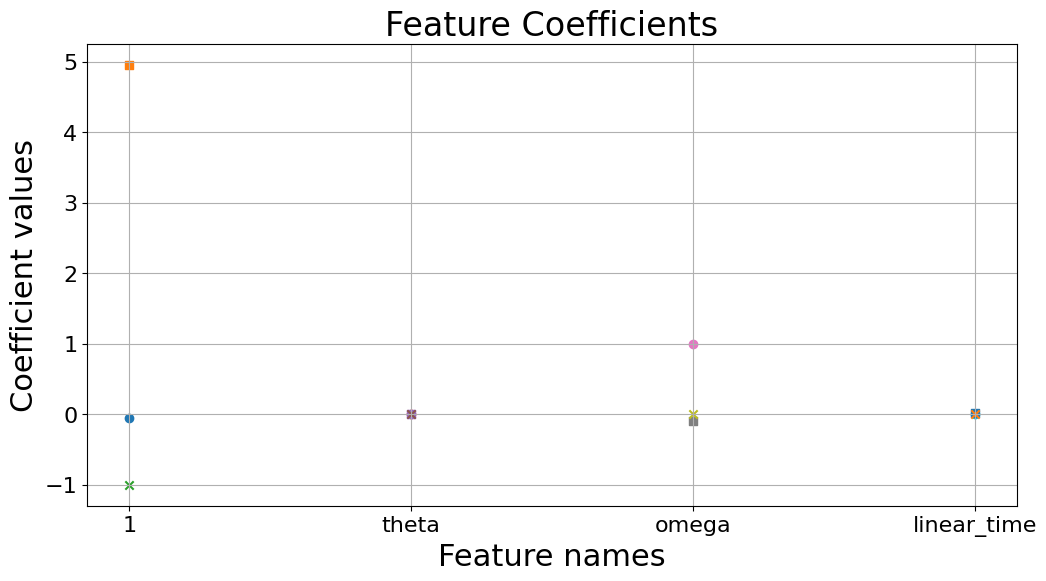

In [93]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_coefficients(feature_names, mean_ensemble):
    # Assume that each row of mean_ensemble corresponds to an equation
    # and each column corresponds to a feature.
    
    num_equations = mean_ensemble.shape[0]
    num_features = len(feature_names)
    
    # Check if the number of features matches the size of the mean_ensemble
    if mean_ensemble.shape[1] != num_features:
        raise ValueError("The number of features does not match the mean ensemble shape.")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.title("Feature Coefficients", fontsize=24)
    plt.xlabel("Feature names", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)

    # Define markers for each equation for clarity
    markers = ['o', 's', 'x']
    labels = ['Equation for theta dot', 'Equation for omega dot', 'Equation for linear time dot']

    # Loop over each feature and plot the coefficients for each equation
    for i in range(num_features):
        for eq in range(num_equations):
            plt.scatter(
                i,  # x position for this feature
                mean_ensemble[eq, i],  # y position for the coefficient of this feature
                label=labels[eq] if i == 0 else "",
                marker=markers[eq]
            )
    
    # Customize ticks and labels
    plt.xticks(ticks=np.arange(num_features), labels=feature_names, fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    # Only call legend once to prevent duplicate labels
    if i == 0:
        plt.legend(fontsize=14)
    plt.show()

# Call the function with the mean ensemble coefficients
plot_feature_coefficients(feature_names, mean_ensemble)


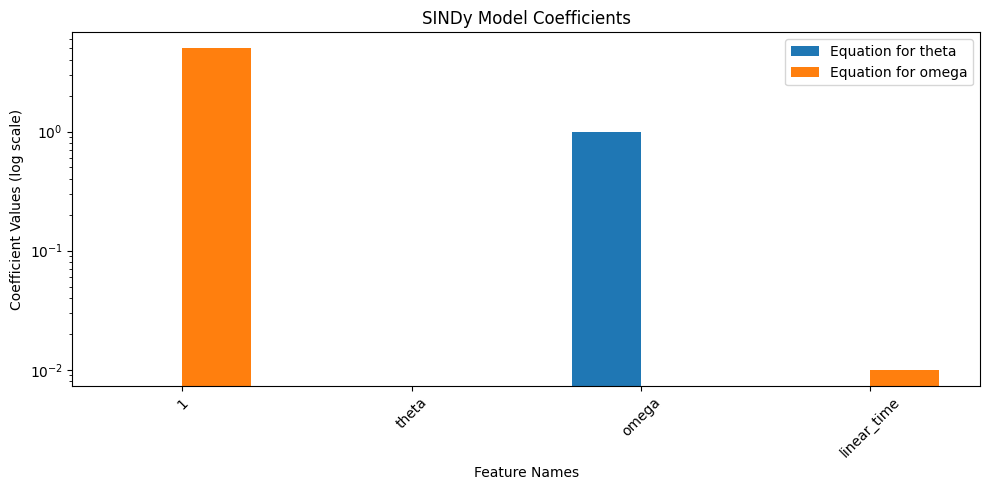

In [92]:
plt.figure(figsize=(10, 5))

# Plot coefficients for the 'theta' equation
plt.bar(np.arange(len(actual_feature_names)) - 0.15, coefs_theta, width=0.3, label="Equation for theta")

# Plot coefficients for the 'omega' equation
plt.bar(np.arange(len(actual_feature_names)) + 0.15, coefs_omega, width=0.3, label="Equation for omega")

plt.xlabel('Feature Names')
plt.ylabel('Coefficient Values (log scale)')
plt.title('SINDy Model Coefficients')
plt.yscale('log')  # Apply logarithmic scale
plt.xticks(ticks=np.arange(len(actual_feature_names)), labels=actual_feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Coefficients for theta equation: [-2.52177533e-04  0.00000000e+00  9.99822870e-01  0.00000000e+00]


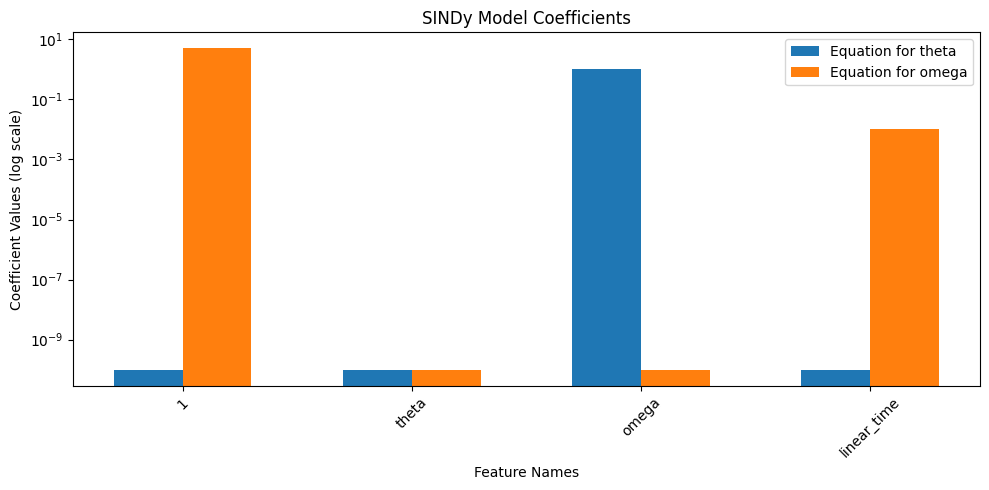

In [80]:
print("Coefficients for theta equation:", coefs_theta)

plt.figure(figsize=(10, 5))

# Adjust the position indices if necessary
position_indices = np.arange(len(actual_feature_names))

# Plot coefficients for the 'theta' equation
# Ensure that the value is not zero or too small
theta_bar = plt.bar(position_indices - 0.15, np.maximum(coefs_theta, 1e-10), width=0.3, label="Equation for theta")

# Plot coefficients for the 'omega' equation
# Use np.maximum to avoid plotting zero values in log scale
omega_bar = plt.bar(position_indices + 0.15, np.maximum(coefs_omega, 1e-10), width=0.3, label="Equation for omega")

plt.xlabel('Feature Names')
plt.ylabel('Coefficient Values (log scale)')
plt.title('SINDy Model Coefficients')
plt.yscale('log')  # Apply logarithmic scale
plt.xticks(ticks=position_indices, labels=actual_feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 4. try piecewise function

In [12]:
def piecewise_function(t):
    # Vectorized handling of different conditions
    return np.where(t < 300, -1, np.where(t < 600, 0, 1))

def piecewise_t(t, y):
    theta, omega = y
    theta_dot = omega
    omega_dot = -c1 * omega - c2 * theta + piecewise_function(np.array([t]))[0] 
    return [theta_dot, omega_dot]


In [92]:
dt = 1
t_train = np.arange(0, 900, dt) 
x0_train = [-0.1, 0.01]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(piecewise_t, t_train_span, x0_train, t_eval=t_train).y.T

# Add time as a feature
time_feature = t_train.reshape(-1, 1)  # Make it a column vector
x_train_augmented = np.hstack([x_train, time_feature])

# Feature names for SINDy 
feature_names = ["theta", "omega", "time"]

# Create a custom library for -t and a standard polynomial library
custom_library = ps.CustomLibrary(library_functions=[piecewise_function])
polynomial_library = ps.PolynomialLibrary()  

# Combine the custom library with the polynomial library using the + operator
combined_library = custom_library + polynomial_library

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-10)

# Create a SINDy model with the combined library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=combined_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=6)

(theta)' = 0.162591 f0(theta) + 0.105582 f0(omega) + -0.384713 f0(time) + -0.162591 1 + -0.000046 theta + 0.980770 omega + -0.016864 time + 0.000023 omega^2 + 0.000056 omega time
(omega)' = 0.171480 f0(theta) + -0.023554 f0(omega) + 0.711081 f0(time) + -0.171480 1 + -0.000257 theta + -0.048354 omega + -0.045728 time + -0.000062 omega^2 + 0.000097 omega time + 0.000042 time^2
(time)' = -0.500000 f0(theta) + 0.500000 1


In [13]:
import numpy as np
import pysindy as ps
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
c1 = 1e-3
c2 = 1e-5

# Piecewise function
def piecewise_function(t):
    return np.piecewise(t, [t < 300, (t >= 300) & (t < 600), t >= 600], [-1, 0, 1])

# ODEs system with piecewise function
def piecewise_t(t, y):
    theta, omega = y
    theta_dot = omega
    omega_dot = -c1 * omega - c2 * theta + piecewise_function(t)
    return [theta_dot, omega_dot]

# Generate measurement data
dt = 1
t_train = np.arange(0, 900, dt)
x0_train = [-0.01, 0.001]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(piecewise_t, t_train_span, x0_train, t_eval=t_train).y.T

# Add time as a linear feature
piecewise_time_feature = t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, piecewise_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "piecewise_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary(degree=1)

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-50)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt)
model.print(precision=5)
print("Model Score:", model.score(x_train_augmented, t=dt))


(theta)' = -0.00267 1 + 1.00002 omega + 0.00002 piecewise_time
(omega)' = -1.03183 1 + -0.00002 theta + 0.00079 omega + 0.00140 piecewise_time
(piecewise_time)' = 1.00000 1
Model Score: 0.6427356343490929


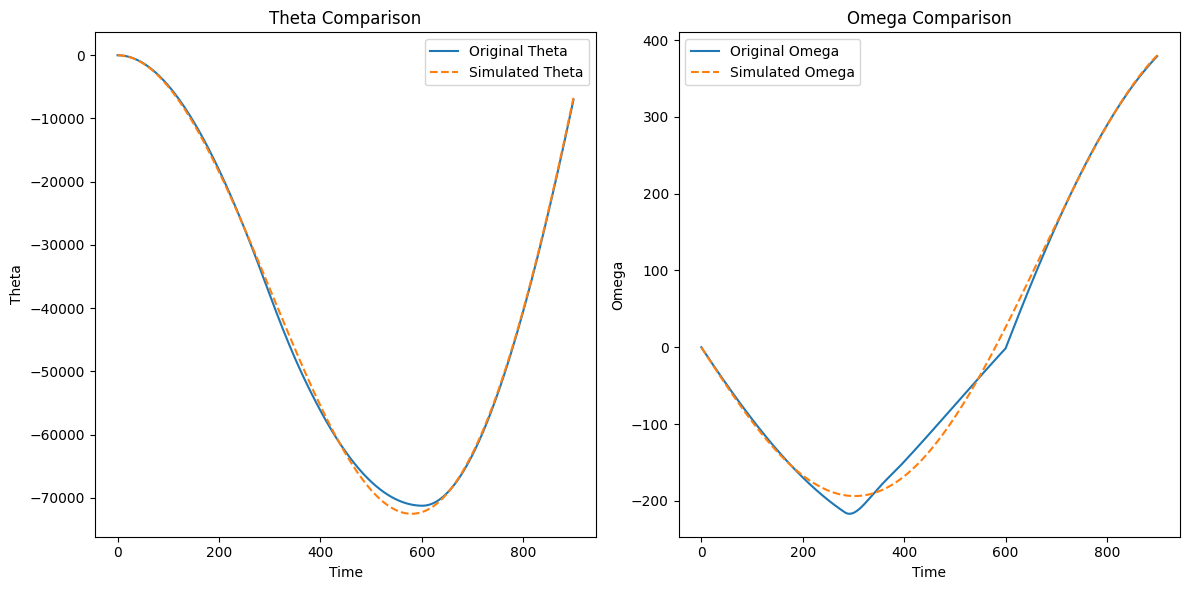

In [14]:
# Augment initial condition with the starting time (0 in this case)
x0_augmented = np.array([x0_train[0], x0_train[1], 0])  # Append 0 for time

# Simulate the dynamics using the SINDy model
x_simulated = model.simulate(x0_augmented, t_train)

# Extract original and simulated theta and omega
original_theta = x_train[:, 0]
simulated_theta = x_simulated[:, 0]
original_omega = x_train[:, 1]
simulated_omega = x_simulated[:, 1]

# Plotting
plt.figure(figsize=(12, 6))

# Plot original and simulated theta
plt.subplot(1, 2, 1)
plt.plot(t_train, original_theta, label='Original Theta')
plt.plot(t_train, simulated_theta, label='Simulated Theta', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Theta Comparison')
plt.legend()

# Plot original and simulated omega
plt.subplot(1, 2, 2)
plt.plot(t_train, original_omega, label='Original Omega')
plt.plot(t_train, simulated_omega, label='Simulated Omega', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Omega')
plt.title('Omega Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [123]:
%store -r bal

In [124]:
bal

Time        f50     omega
0      2019-11-27 10:17:19  49.995914 -0.025673
1      2019-11-27 10:17:20  50.002309  0.014509
2      2019-11-27 10:17:21  50.012899  0.081047
3      2019-11-27 10:17:22  50.018296  0.114954
4      2019-11-27 10:17:23  50.020671  0.129883
...                    ...        ...       ...
409466 2019-12-02 04:01:45  50.044756  0.281207
409467 2019-12-02 04:01:46  50.046004  0.289050
409468 2019-12-02 04:01:47  50.046276  0.290759
409469 2019-12-02 04:01:48  50.045041  0.283003
409470 2019-12-02 04:01:49  50.043080  0.270682

[409471 rows x 3 columns]

In [125]:
start_time = pd.to_datetime('2019-11-28 00:00:00')

# Calculate end time (one hour later)
end_time = start_time + pd.Timedelta(hours=1)

# Filter the dataset for the specific one-hour range
one_hour_data = bal[(bal['Time'] >= start_time) & (bal['Time'] < end_time)]

In [126]:
one_hour_data

Time        f50     omega
49361 2019-11-28 00:00:00  49.961377 -0.242678
49362 2019-11-28 00:00:01  49.961990 -0.238825
49363 2019-11-28 00:00:02  49.961652 -0.240947
49364 2019-11-28 00:00:03  49.959465 -0.254687
49365 2019-11-28 00:00:04  49.961390 -0.242596
...                   ...        ...       ...
52956 2019-11-28 00:59:55  49.930430 -0.437122
52957 2019-11-28 00:59:56  49.930258 -0.438205
52958 2019-11-28 00:59:57  49.931216 -0.432181
52959 2019-11-28 00:59:58  49.932906 -0.421562
52960 2019-11-28 00:59:59  49.934989 -0.408478

[3600 rows x 3 columns]

In [127]:
from scipy.ndimage import gaussian_filter1d

In [128]:
# Dividing data into four 15-minute segments
segment_duration = pd.Timedelta(minutes=15)
segments = [one_hour_data[(one_hour_data['Time'] >= one_hour_data['Time'].min() + i * segment_duration) & 
                          (one_hour_data['Time'] < one_hour_data['Time'].min() + (i+1) * segment_duration)] 
            for i in range(4)]

# Applying Gaussian filter to the omega variable in each segment
sigma = 60  
filtered_segments = [gaussian_filter1d(segment['omega'], sigma) for segment in segments]


In [129]:
import pywt
def integrate_data(data, dt=1, initial_value=-0.001):
    integrated_data = np.full(len(data), initial_value)
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt
    return integrated_data

In [130]:
theta_segments = []
wavelet = 'db4'
level = 12
sigma = 20

for segment in segments:
    # Applying Gaussian Filter
    gaussian_filtered_data = gaussian_filter1d(segment['omega'], sigma)
    
    # Applying Wavelet Filter
    coeffs = pywt.wavedec(gaussian_filtered_data, wavelet, level=level)
    coeffs[1:] = [np.zeros_like(coeff) for coeff in coeffs[1:]]  # Zero out coefficients
    wavelet_filtered_data = pywt.waverec(coeffs, wavelet)
    
    # Store the wavelet filtered data in the DataFrame using .loc
    segment.loc[:, 'wavelet_filtered_omega'] = wavelet_filtered_data

    # Integrating the Wavelet Filtered Data
    theta = integrate_data(wavelet_filtered_data)
    
    # Storing theta in the DataFrame using .loc
    segment.loc[:, 'theta'] = theta

    # Optional: Collecting the theta segments for further analysis
    theta_segments.append(theta)


C:\Users\wp7528\AppData\Local\Temp\ipykernel_18396\3984461729.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment.loc[:, 'wavelet_filtered_omega'] = wavelet_filtered_data
C:\Users\wp7528\AppData\Local\Temp\ipykernel_18396\3984461729.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment.loc[:, 'theta'] = theta
C:\Users\wp7528\AppData\Local\Temp\ipykernel_18396\3984461729.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [131]:
segments

[                     Time        f50     omega  wavelet_filtered_omega  \
 49361 2019-11-28 00:00:00  49.961377 -0.242678               -0.000554   
 49362 2019-11-28 00:00:01  49.961990 -0.238825               -0.000399   
 49363 2019-11-28 00:00:02  49.961652 -0.240947               -0.000243   
 49364 2019-11-28 00:00:03  49.959465 -0.254687               -0.000087   
 49365 2019-11-28 00:00:04  49.961390 -0.242596                0.000069   
 ...                   ...        ...       ...                     ...   
 50256 2019-11-28 00:14:55  50.040049  0.251635                0.076476   
 50257 2019-11-28 00:14:56  50.042671  0.268107                0.076515   
 50258 2019-11-28 00:14:57  50.046107  0.289701                0.076554   
 50259 2019-11-28 00:14:58  50.049084  0.308401                0.076592   
 50260 2019-11-28 00:14:59  50.049867  0.313327                0.076630   
 
            theta  
 49361  -0.001000  
 49362  -0.001399  
 49363  -0.001641  
 49364  -0.001728 

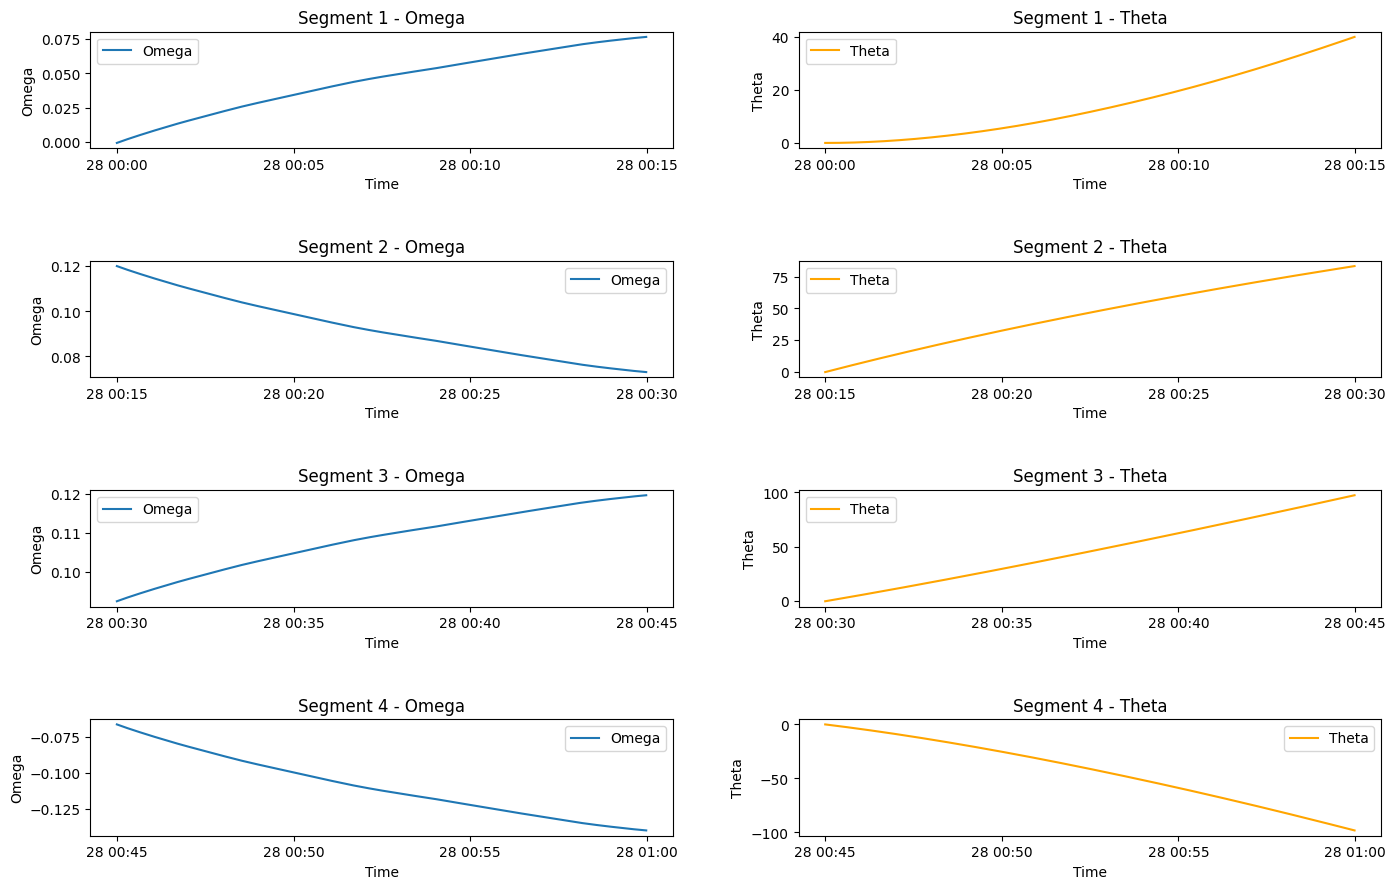

In [133]:
import matplotlib.pyplot as plt

# Plotting omega and theta for each segment
fig, axes = plt.subplots(nrows=len(segments), ncols=2, figsize=(15, 10))
fig.tight_layout(pad=6.0)

for i, segment in enumerate(segments):
    # Plotting omega
    axes[i][0].plot(segment['Time'], segment['wavelet_filtered_omega'], label='Omega')
    axes[i][0].set_title(f'Segment {i+1} - Omega')
    axes[i][0].set_xlabel('Time')
    axes[i][0].set_ylabel('Omega')
    axes[i][0].legend()

    # Plotting theta
    axes[i][1].plot(segment['Time'], segment['theta'], label='Theta', color='orange')
    axes[i][1].set_title(f'Segment {i+1} - Theta')
    axes[i][1].set_xlabel('Time')
    axes[i][1].set_ylabel('Theta')
    axes[i][1].legend()

plt.show()



In [134]:
sindy_results = []

for i, segment in enumerate(segments):
    
    X = np.stack((segment['theta'], segment['wavelet_filtered_omega']), axis=-1)

    # Define and fit the SINDy model
    differentiation_method = ps.FiniteDifference(order=2)
    optimizer = ps.STLSQ(threshold=1e-10)
    feature_names = ["theta", "omega"]

    sindy_model = ps.SINDy(
        differentiation_method=differentiation_method,
        feature_names=feature_names,
        optimizer=optimizer
    )

    sindy_model.fit(X, t=dt)
    
    # Store the model and its score
    model_str = sindy_model.print(precision=8)
    model_score = sindy_model.score(X, t=dt)
    sindy_results.append((model_str, model_score))

sindy_results  # Displaying the results for each segment

(theta)' = 0.00007332 1 + -0.00000579 theta + 0.99927115 omega + -0.00000009 theta^2 + 0.00009900 theta omega + 0.01127983 omega^2
(omega)' = 0.00014692 1 + -0.00001178 theta + -0.00147959 omega + -0.00000017 theta^2 + 0.00019764 theta omega + 0.02394182 omega^2
(theta)' = 0.00961404 1 + -0.00009792 theta + 0.83757018 omega + 0.00000025 theta^2 + 0.00082957 theta omega + 0.68280751 omega^2
(omega)' = 0.01898454 1 + -0.00019368 theta + -0.32080802 omega + 0.00000049 theta^2 + 0.00164127 theta omega + 1.34875219 omega^2
(theta)' = -0.00172823 1 + -0.00001480 theta + 1.03681404 omega + -0.00000002 theta^2 + 0.00014928 theta omega + -0.19299411 omega^2
(omega)' = -0.00340298 1 + -0.00002941 theta + 0.07244393 omega + -0.00000004 theta^2 + 0.00029607 theta omega + -0.37942608 omega^2
(theta)' = 0.00009999 1 + -0.00000859 theta + 1.00457554 omega + 0.00000003 theta^2 + -0.00009069 theta omega + 0.03040243 omega^2
(omega)' = 0.00019312 1 + -0.00001719 theta + 0.00893636 omega + 0.00000007 the

[(None, 0.9859295319704974),
 (None, 0.9823992804886634),
 (None, 0.9849888703082232),
 (None, 0.9853168333201795)]

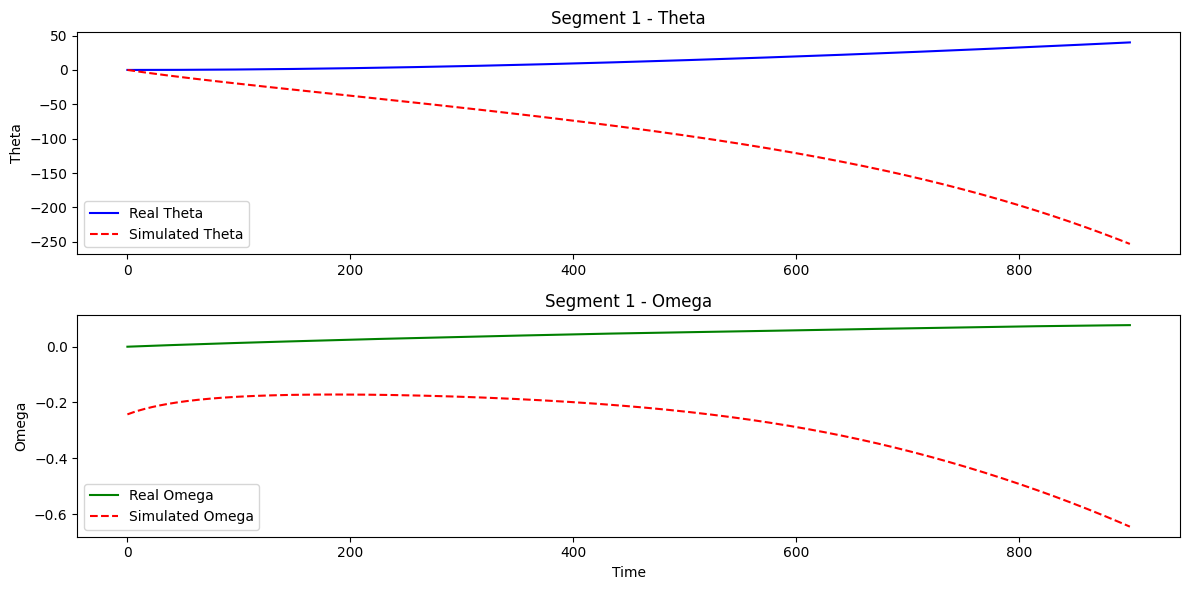

C:\Users\wp7528\AppData\Roaming\Python\Python311\site-packages\pysindy\utils\axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [135]:
import matplotlib.pyplot as plt

# Assuming dt is defined
for i, (segment, (model_str, model_score)) in enumerate(zip(segments, sindy_results)):
    # Use the first row of the segment as initial conditions
    initial_conditions = segment[['theta', 'omega']].iloc[0].values
    
    # Simulate the dynamics
    t_sim = np.arange(0, len(segment) * dt, dt)
    X_sim = sindy_model.simulate(initial_conditions, t_sim)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot real vs simulated theta
    plt.subplot(2, 1, 1)
    plt.plot(t_sim, segment['theta'], 'b', label='Real Theta')
    plt.plot(t_sim, X_sim[:, 0], 'r--', label='Simulated Theta')
    plt.title(f'Segment {i+1} - Theta')
    plt.ylabel('Theta')
    plt.legend()

    # Plot real vs simulated omega
    plt.subplot(2, 1, 2)
    plt.plot(t_sim, segment['wavelet_filtered_omega'], 'g', label='Real Omega')
    plt.plot(t_sim, X_sim[:, 1], 'r--', label='Simulated Omega')
    plt.title(f'Segment {i+1} - Omega')
    plt.ylabel('Omega')
    plt.xlabel('Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [145]:
dt = 1  

sindy_models = []

for i, segment in enumerate(segments):
    # Generate the time feature
    t_segment = np.arange(segment.shape[0]) * dt

    # Augment the data with the time feature
    x_segment = segment[['theta', 'wavelet_filtered_omega']].values
    x_segment_augmented = np.hstack([x_segment, -t_segment.reshape(-1, 1)])

    # Create a custom library for -t and a standard polynomial library
    # Use Polynomial Library with degree 1
    polynomial_library = ps.PolynomialLibrary(degree=2)
    
    # Sparse regression optimizer
    sparse_regression_optimizer = ps.STLSQ(threshold=1e-50)
    
    # Create a SINDy model with the polynomial library
    model = ps.SINDy(feature_names=["theta", "omega", "time"], 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

    model.fit(x_segment_augmented, t=dt)

    # Store the model and its score
    model_str = model.print()
    
    sindy_models.append({
        "model": model,
        "segment": segment,
        "segment_index": i
    })
    


(theta)' = 1.002 omega + 0.008 theta omega + 3.548 omega^2 + 0.001 omega time
(omega)' = 0.005 omega + 0.017 theta omega + 7.274 omega^2 + 0.002 omega time
(time)' = -1.000 1
(theta)' = -0.084 1 + 0.001 theta + 2.403 omega + -0.014 theta omega + -5.850 omega^2 + -0.001 omega time
(omega)' = -0.173 1 + 0.003 theta + 2.876 omega + -0.028 theta omega + -11.992 omega^2 + -0.001 omega time
(time)' = -1.000 1
(theta)' = 0.088 1 + -0.002 theta + -0.892 omega + 0.024 theta omega + 10.212 omega^2 + 0.003 omega time
(omega)' = 0.180 1 + -0.005 theta + -3.878 omega + -0.001 time + 0.048 theta omega + 20.934 omega^2 + 0.006 omega time
(time)' = -1.000 1
(theta)' = -0.017 1 + -0.001 theta + 0.503 omega + -0.009 theta omega + -3.725 omega^2 + 0.002 omega time
(omega)' = -0.034 1 + -0.001 theta + -1.018 omega + -0.018 theta omega + -7.637 omega^2 + 0.003 omega time
(time)' = -1.000 1


In [147]:
sindy_models

[{'model': SINDy(differentiation_method=FiniteDifference(),
        feature_library=PolynomialLibrary(),
        feature_names=['theta', 'omega', 'time'],
        optimizer=STLSQ(threshold=1e-50)),
  'segment':                      Time        f50     omega  wavelet_filtered_omega  \
  49361 2019-11-28 00:00:00  49.961377 -0.242678               -0.000554   
  49362 2019-11-28 00:00:01  49.961990 -0.238825               -0.000399   
  49363 2019-11-28 00:00:02  49.961652 -0.240947               -0.000243   
  49364 2019-11-28 00:00:03  49.959465 -0.254687               -0.000087   
  49365 2019-11-28 00:00:04  49.961390 -0.242596                0.000069   
  ...                   ...        ...       ...                     ...   
  50256 2019-11-28 00:14:55  50.040049  0.251635                0.076476   
  50257 2019-11-28 00:14:56  50.042671  0.268107                0.076515   
  50258 2019-11-28 00:14:57  50.046107  0.289701                0.076554   
  50259 2019-11-28 00:14:58  50

In [149]:
def plot_and_simulate_with_sindy(model, segment, dt, segment_index):
    """
    Simulate using the SINDy model and plot real vs simulated theta and omega for a given segment.

    Parameters:
    - model: The fitted SINDy model.
    - segment: DataFrame containing the real 'theta' and 'wavelet_filtered_omega' values.
    - dt: Time step for the simulation.
    - segment_index: Index of the current segment for labeling purposes.
    """
    # Initial conditions for the simulation
    initial_conditions = np.hstack((segment[['theta', 'wavelet_filtered_omega']].iloc[0].values, [0]))

    # Time span for the simulation
    total_time = segment.shape[0] * dt
    t_sim = np.linspace(0, total_time, segment.shape[0])

    # Simulate the system
    simulated_data = model.simulate(initial_conditions, t_sim)
    theta_sim = simulated_data[:, 0]
    omega_sim = simulated_data[:, 1]

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot real vs simulated theta
    plt.subplot(2, 1, 1)
    plt.plot(t_sim, segment['theta'], label='Real Theta')
    plt.plot(t_sim, theta_sim, label='Simulated Theta', linestyle='--')
    plt.title(f'Segment {segment_index + 1} - Theta')
    plt.ylabel('Theta')
    plt.legend()

    # Plot real vs simulated omega
    plt.subplot(2, 1, 2)
    plt.plot(t_sim, segment['wavelet_filtered_omega'], label='Real Omega')
    plt.plot(t_sim, omega_sim, label='Simulated Omega', linestyle='--')
    plt.title(f'Segment {segment_index + 1} - Omega')
    plt.ylabel('Omega')
    plt.xlabel('Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

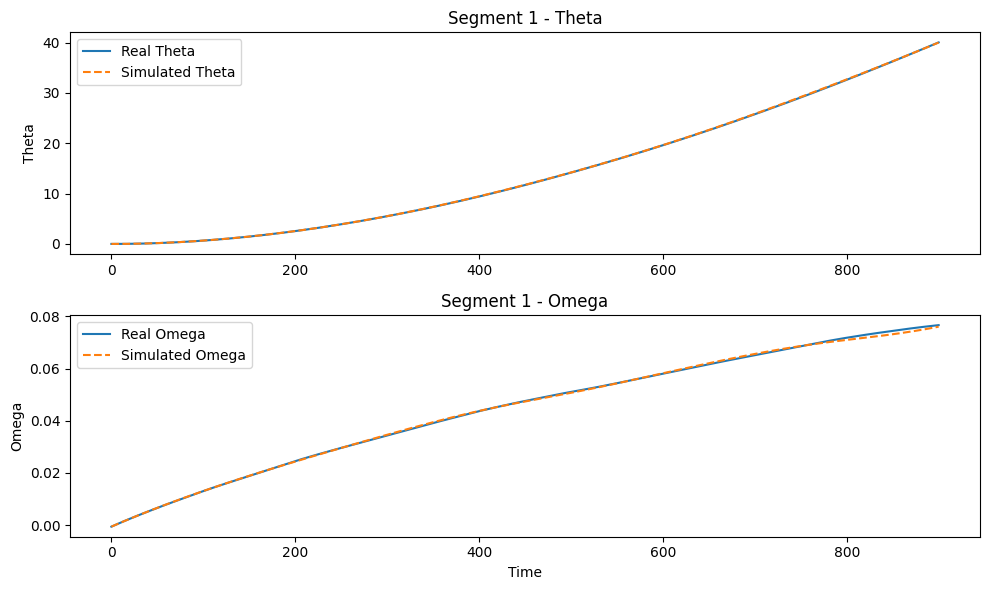

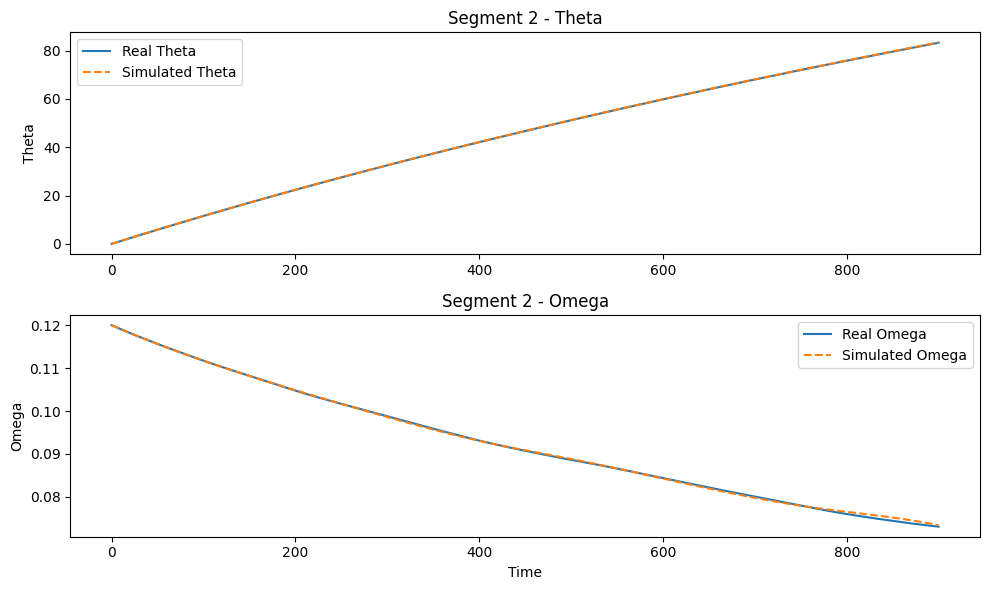

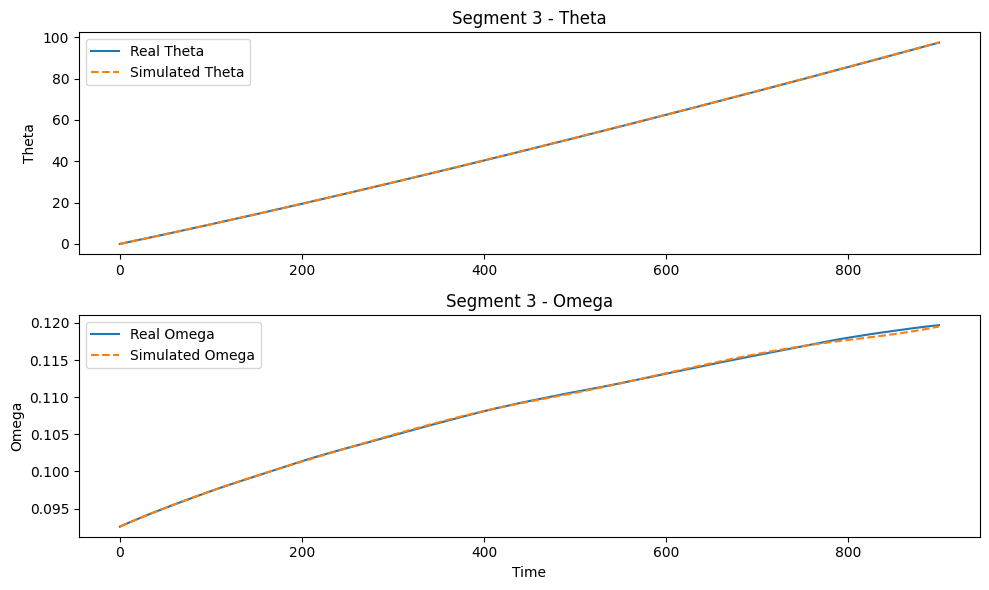

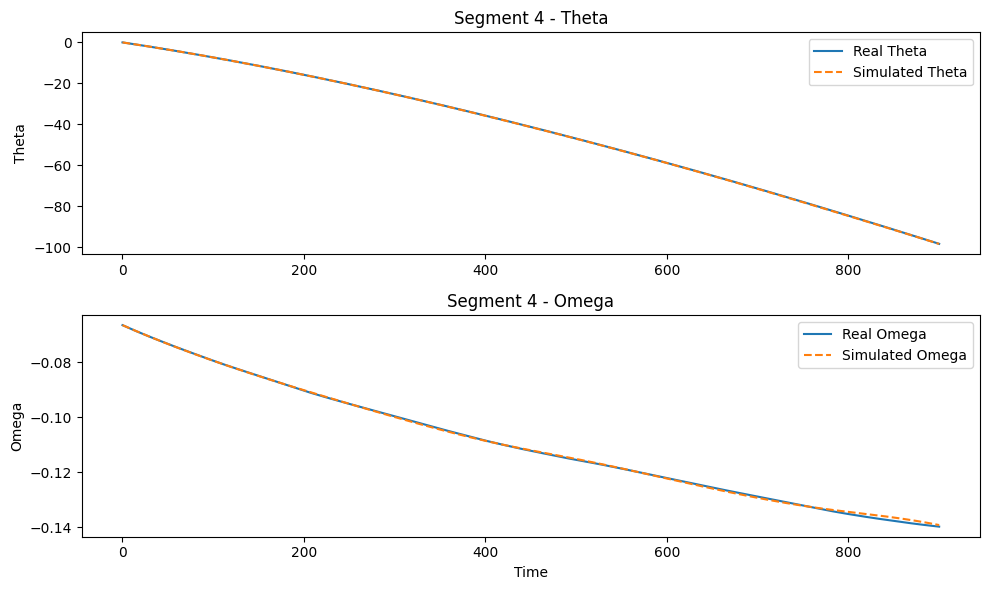

In [150]:
# Assuming sindy_models is already populated with the fitted models and segments
for stored_model in sindy_models:
    plot_and_simulate_with_sindy(stored_model["model"], stored_model["segment"], dt, stored_model["segment_index"])


In [10]:
Irish = np.load('C:/Users/wp7528/Documents/islands_models_ulrich/Stochastic-modelling-of-power-grid-frequency-applied-to-islands/Create_figures/Data_from_Ulrichs_paper/Irish_data.npz')

data = [Irish['freq_model1'],Irish['freq_model2'], Irish['freq_model3'],Irish['freq_model4']]

In [15]:
data = Irish['freq_model1']

In [16]:
data

array([49.9941231 , 49.99429693, 49.99460537, ..., 50.01920012,
       50.01945332, 50.01892678])

In [13]:
 # Here is the model1 function definition
def model1(data, c_1, c_2_decay, Delta_P, epsilon, time_res=1, dispatch=1, delta_t=0.1, t_final=5, factor_daily_profile=0, prim_control_lim=0.15*2*np.pi, prim_weight=1):
    t_steps = int(t_final*3600*24/delta_t)
    time = np.linspace(0.0, t_final, t_steps)
  
    omega = np.zeros([time.size]) 
    theta = np.zeros([time.size])
  
    # Give some small random initial conditions
    theta[0] = np.random.normal(size=1) / 10
    omega[0] = np.random.normal(size=1) / 10
  
    # Generate a Wiener process
    dW = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=[time.size, 1])
    
    for i in range(1, time.size):
        theta[i] = theta[i-1] + delta_t * omega[i-1]
        omega[i] = omega[i-1] + delta_t * c_1 * omega[i-1] + 1 * epsilon * dW[i]
  
    # Return the theta and omega arrays
    return theta, omega

In [14]:
bw_drift = 0.1
bw_diff = 0.1
dist_drift = 500 #for small amount of data choose a larger value for dist_drift: 800
dist_diff = 500

c_1 = KM_Coeff_1(data,dim= 1,time_res = 1,bandwidth = bw_drift,dist = dist_drift, order = 1)

epsilon = KM_Coeff_2(data,dim = 1,time_res = 1,bandwidth = bw_diff,dist = dist_diff,multiplicative_noise = False)

delta_t = 1 #time step for Euler-Maruyama
theta_model_1, omega_model_1 = model1(data,c_1=c_1,c_2_decay=0,Delta_P = 0,epsilon=epsilon,time_res = 1,dispatch = 0,delta_t=delta_t,t_final=5)

AssertionError: Timeseries seems to be (D, N) shaped, transpose it: Timeseries.T

In [24]:
c_1

array([-0.00120249])

In [25]:
X = np.stack((theta_model_1, omega_model_1), axis=-1)

# SINDy part
dt = delta_t
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=1e-25)
feature_names = ["theta", "omega"]  # Both theta and omega as feature names

sindy_model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_names=feature_names,
    optimizer=optimizer
)

sindy_model.fit(X, t=dt)
sindy_model.print()
print("Model Score:", sindy_model.score(X, t=dt))

(theta)' = 0.999 omega
(omega)' = 0.000
Model Score: 0.4996838132649813


In [6]:
def Model2(data,c_1,c_2_decay,Delta_P,epsilon,time_res = 1,dispatch = 1,delta_t=0.1,t_final=5,model=3,factor_daily_profile=0,prim_control_lim = 0.15*2*np.pi,prim_weight = 1):
    t_steps = int(t_final*3600*24/delta_t)
    time = np.linspace(0.0, t_final, t_steps)
  
    omega = np.zeros([time.size]) 
    theta = np.zeros([time.size])
    # Give some small random initial conditions
    theta[0]=np.random.normal(size = 1) / 10    
    omega[0]=np.random.normal(size = 1) / 10
    # Generate a Wiener process with a scale of np.sqrt(delta_t)
    dW = np.random.normal(loc = 0, scale = np.sqrt(delta_t), size = [time.size,1])
    P = np.ones(time.size)
    sign_P = np.zeros(time.size)
    for i in range(1,time.size):
        if dispatch != 0:
            if i % (12*3600/delta_t)  < 6*3600/delta_t:    #greater or equal is important here!!!
                sign_P[i]=1
            else:
                sign_P[i]=-1
            if i % (60*60/delta_t)  < (4/dispatch)*15*60/delta_t:
                P[i] = 1  #*q1_mean_half #0.5
            else:
                P[i] = 1/3     #heuristic choice as the change of the power dispatch at the begin of an hour is normally higher than at other times
            
        theta[i] = theta[i-1] + delta_t * omega[i-1]
        omega[i] = omega[i-1] + delta_t * (   c_1 *omega[i-1] + c_2_decay *c_1  * theta[i-1] + 1*Delta_P*P[i]*sign_P[i] )  + epsilon*dW[i]

    # Return the real data for theta and omega
    return theta, omega


In [7]:
trend = 1
bw_drift = 0.1
bw_diff = 0.1
dist_drift = 500 #for small amount of data choose a larger value for dist_drift: 800
dist_diff = 500
c_1 = KM_Coeff_1(data - trend*data_filter(data),dim= 1,time_res = 1,bandwidth = bw_drift,dist = dist_drift, order = 1)
c_2_decay = trend*exp_decay(data,time_res=1,size = 899)
epsilon =   epsilon = KM_Coeff_2(data - trend*data_filter(data),dim = 1,time_res = 1,bandwidth = bw_diff,dist = dist_diff,multiplicative_noise = False)
Delta_P = power_mismatch(data_filter(data,sigma = 6),avg_for_each_hour = False,dispatch=1,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)

NameError: name 'data' is not defined

In [35]:
theta_2, omega_2 = model2(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,epsilon=epsilon,time_res = 1,dispatch = 0,delta_t=delta_t,t_final=5)

In [37]:
X = np.stack((theta_2, omega_2), axis=-1)

# SINDy part
dt = delta_t
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=1e-35)
feature_names = ["theta", "omega"]  # Both theta and omega as feature names

sindy_model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_names=feature_names,
    optimizer=optimizer
)

sindy_model.fit(X, t=dt)
sindy_model.print()
print("Model Score:", sindy_model.score(X, t=dt))

(theta)' = 0.001 1 + 0.987 omega + 0.002 omega^2
(omega)' = 0.000
Model Score: 0.4943480388882194


In [38]:
c_2_decay

2.750906325357079e-05

In [6]:
def model3(data, c_1, c_2_decay, Delta_P, epsilon, time_res=1, dispatch=1, delta_t=0.01, t_final=100, factor_daily_profile=0, prim_control_lim=0.15*2*np.pi, prim_weight=1):
    t_steps = int(t_final / delta_t)
    time = np.arange(0, t_final, delta_t)

    omega = np.zeros(t_steps)
    theta = np.zeros(t_steps)

    # Initialize with small random initial conditions
    theta[0] = np.random.normal(scale=0.1)  # Adjust the scale as needed
    omega[0] = np.random.normal(scale=0.1)  # Adjust the scale as needed

    # Generate a Wiener process
    dW = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=t_steps)
    
    for i in range(1, t_steps):
        # Update the time-varying parameters based on your real data
        # For example, you can set time_varying_Delta_P using real data
        time_varying_Delta_P = Delta_P  # Treat Delta_P as a scalar
    
        # Make sure epsilon is an array or scalar compatible with element-wise multiplication
        epsilon_model_3 = epsilon * np.sqrt(2 * (omega[i - 1]**2 * epsilon + epsilon))
        noise_term = epsilon_model_3 * dW[i]  # Use real noise data

        # Update the dynamics of theta and omega based on the ODE
        theta_dot = omega[i - 1]
        omega_dot = (c_1[0] * omega[i - 1]**3 + c_1[1] * omega[i - 1]) + c_2_decay * (3 * c_1[0] * omega[i - 1]**2 + c_1[1]) * theta[i - 1] + time_varying_Delta_P + noise_term

    # Return the real data for theta and omega
    return theta, omega



In [9]:
c_1 = KM_Coeff_1(data - trend * data_filter(data), dim=1, time_res=1, bandwidth=bw_drift, dist=dist_drift, order=3)
c_2_decay = trend * exp_decay(data, time_res=1, size=899)
epsilon_values, epsilon_scalar = KM_Coeff_2(data - trend * data_filter(data), dim=1, time_res=1, bandwidth=bw_diff, dist=dist_diff, multiplicative_noise=True)

# Unpack epsilon_values and use it for epsilon in the model3 function call
epsilon = epsilon_values[0]  # Choose the first value from the tuple

# Now, you can call the model3 function
theta_3, omega_3 = model3(data, c_1=c_1, c_2_decay=c_2_decay, Delta_P=Delta_P, epsilon=epsilon, time_res=1, dispatch=0, delta_t=dt, t_final=100)


In [10]:
c_1

array([-0.0347755 , -0.02149541])

In [11]:
c_2_decay

2.7514135043251617e-05

In [53]:
X = np.stack((theta_3, omega_3), axis=-1)

# SINDy part
dt = delta_t
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=1e-35)
feature_names = ["theta", "omega"]  # Both theta and omega as feature names

sindy_model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_names=feature_names,
    optimizer=optimizer
)

sindy_model.fit(X, t=dt)
sindy_model.print()
print("Model Score:", sindy_model.score(X, t=dt))

(theta)' = -0.161 theta + 0.458 omega + -0.008 theta^2 + 0.022 theta omega + -0.062 omega^2
(omega)' = 0.001 1 + 0.458 theta + -1.307 omega + 0.022 theta^2 + -0.062 theta omega + 0.176 omega^2
Model Score: 0.8994005091566062


In [13]:
import numpy as np
from scipy.integrate import solve_ivp

# Define the model4 function
def model4(data, c_1, c_2_decay, Delta_P, epsilon, time_res=1, dispatch=1, delta_t=0.01, t_final=100, factor_daily_profile=0, prim_control_lim=0.15*2*np.pi, prim_weight=1):
    # Time step and span
    t_train = np.arange(0, t_final, delta_t)
    t_train_span = (t_train[0], t_train[-1])

    # Initial conditions
    x0_train = [0.1, 0.1]

    # Generate a Wiener process (consider the length of the process)
    dW_t = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=len(t_train))

    # Helper function to calculate epsilon_model_4 term
    def calc_epsilon_model_4(omega_prev, epsilon):
        return np.sqrt(2 * (epsilon[0] * omega_prev ** 2 + epsilon[1]))

    # Define the ODE function for model4
    def model4_ode(t, x):
        theta, omega = x

        # Derive the current index from the time variable
        index = int(t // delta_t)

        # Get the noise term at the current index (bounded by array length)
        epsilon_model_4_term = calc_epsilon_model_4(omega, epsilon)
        noise_term = epsilon_model_4_term * dW_t[min(index, len(dW_t) - 1)]

        # Calculate derivatives
        theta_dot = omega
        omega_dot = c_1 * omega + c_2_decay * c_1 * theta + Delta_P + noise_term

        return [theta_dot, omega_dot]

    # Solve the ODE
    result = solve_ivp(model4_ode, t_train_span, x0_train, t_eval=t_train)

    # Parse the result
    theta_train = result.y[0]
    omega_train = result.y[1]

    return theta_train, omega_train

In [9]:
trend = 1
dist_theta, dist_omega = 15,15
c_1 = KM_Coeff_1((data - trend*data_filter(data)),dim= 2,time_res = 1,bandwidth = bw_drift,dist = [dist_theta, dist_omega], order = 1)[0]
c_2 = KM_Coeff_1((data - trend*data_filter(data)),dim= 2,time_res = 1,bandwidth = bw_drift,dist = [dist_theta, dist_omega], order = 1)[1]
Delta_P = 0 
epsilon =   KM_Coeff_2(data - trend*data_filter(data,sigma=300), dim = 2, time_res = 1, bandwidth = bw_diff, dist = [dist_theta, dist_omega], multiplicative_noise = True) #sigma = 60
delta_t = 1 #time step for Euler-Maruyama

#theta_4, omega_4 = model4(data, c_1, c_2_decay, Delta_P, epsilon, delta_t=0.01, t_final=100)

In [10]:
c_1

-0.02124645601908453

In [11]:
c_2

-0.0009164386406812072

In [59]:
X = np.stack((theta, omega), axis=-1)

# SINDy part
dt = delta_t
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=1e-55)
feature_names = ["theta", "omega"]  # Both theta and omega as feature names

sindy_model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_names=feature_names,
    optimizer=optimizer
)

sindy_model.fit(X, t=dt)
sindy_model.print()
print("Model Score:", sindy_model.score(X, t=dt))

(theta)' = 0.010 omega
(omega)' = -0.001 1 + 0.001 theta + 0.020 omega + -0.004 theta omega + -0.083 omega^2
Model Score: 0.5482319697560378
